In [1]:
import warnings
warnings.simplefilter("ignore")

### Install iNNvestigate 

In [2]:
%%capture
!pip install --user innvestigate

In [3]:
import imp
import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import tensorflow as tf
import keras
import keras.backend as k
import keras.models
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve, auc
import innvestigate as innv
import innvestigate.utils as iutils
import varsList
from sklearn.model_selection import train_test_split
from ROOT import TMVA, TFile, TTree, TCut, TRandom3

Using TensorFlow backend.


Welcome to JupyROOT 6.20/06


## Load in data
Choose a sample

In [4]:
dirList = next(os.walk(os.getcwd()))[1]
sampleDir = widgets.Dropdown( options = dirList )
sampleDir

Dropdown(options=('.git', '.sys.v#.Correlation Consideration.ipynb', '.sys.v#.Correlation Pandas.ipynb', '.sys…

In [37]:
sigSample = widgets.Dropdown( options = os.listdir( sampleDir.value ) )
sigSample

Dropdown(options=('TTTT_TuneCP5_13TeV-amcatnlo-pythia8_hadd.root', 'TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8_tt1…

In [38]:
bkgSamples = widgets.SelectMultiple( options = os.listdir( sampleDir.value ) )
bkgSamples

SelectMultiple(options=('TTTT_TuneCP5_13TeV-amcatnlo-pythia8_hadd.root', 'TTTo2L2Nu_TuneCP5_13TeV-powheg-pythi…

In [39]:
sigFile = TFile.Open( sampleDir.value + "/" + sigSample.value )
bkgFiles = {}
for file in bkgSamples.value:
    bkgFiles[file] = TFile.Open( sampleDir.value + "/" + file )

In [40]:
sigTree = sigFile.Get( "ljmet" )
bkgTrees = {}
for file in bkgSamples.value:
    bkgTrees[file] = bkgFiles[file].Get( "ljmet" )

In [41]:
cutVars = [
    "leptonPt_MultiLepCalc","isElectron","isMuon","corr_met_MultiLepCalc","MT_lepMet",
    "minDR_lepJet","AK4HT","DataPastTriggerX","MCPastTriggerX","NJetsCSVwithSF_MultiLepCalc",
    "NJets_JetSubCalc","triggerXSF","pileupWeight","lepIdSF","EGammaGsfSF","isoSF",
    "L1NonPrefiringProb_CommonCalc","xsecEff","MCWeight_MultiLepCalc"
]

leptonPt = 50.
isElectron = 1
isMuon = 1
corr_met = 60.
MT_lepMet = 60.
minDR_lepJet = 0.4
AK4HT = 510.
DataPastTriggerX = 1
MCPastTriggerX = 1
bJets = 2
nJets = 6

In [42]:
sigCut = np.asarray(
    sigTree.AsMatrix( cutVars )
)

bkgCut = {}

for file in bkgSamples.value:
    bkgCut[file] = np.asarray(
        bkgTrees[file].AsMatrix( cutVars )
    )

In [43]:
bkgCutComb = np.concatenate([bkgCut[file] for file in bkgSamples.value])

In [44]:
sigCutSort = sigCut[np.lexsort((sigCut[:,3],sigCut[:,0]))]
bkgCutSort = bkgCutComb[np.lexsort((bkgCutComb[:,3],bkgCutComb[:,0]))]

### Apply event selection

In [45]:
sigMask = np.zeros(np.shape(sigCutSort)[0])
bkgMask = np.zeros(np.shape(bkgCutSort)[0])
for i in range(np.shape(sigCutSort)[0]):
    if( ( sigCutSort[i,0] > leptonPt and sigCutSort[i,1] == isElectron ) or ( sigCutSort[i,0] > leptonPt and sigCutSort[i,2] == isMuon ) ):
        if( sigCutSort[i,3] > corr_met and sigCutSort[i,4] > MT_lepMet and sigCutSort[i,5] > minDR_lepJet and sigCutSort[i,6] > AK4HT ):
            if( sigCutSort[i,7] == DataPastTriggerX and sigCutSort[i,8] == MCPastTriggerX ):
                if( sigCutSort[i,9] >= bJets and sigCutSort[i,10] >= nJets ):
                    sigMask[i] = 1
for i in range(np.shape(bkgCutSort)[0]):
    if( ( bkgCutSort[i,0] > leptonPt and bkgCutSort[i,1] == isElectron ) or ( bkgCutSort[i,0] > leptonPt and bkgCutSort[i,2] == isMuon ) ):
        if( bkgCutSort[i,3] > corr_met and bkgCutSort[i,4] > MT_lepMet and bkgCutSort[i,5] > minDR_lepJet and bkgCutSort[i,6] > AK4HT ):
            if( bkgCutSort[i,7] == DataPastTriggerX and bkgCutSort[i,8] == MCPastTriggerX ):
                if( bkgCutSort[i,9] >= bJets and bkgCutSort[i,10] >= nJets ):
                    bkgMask[i] = 1

In [46]:
varList = np.asarray(varsList.varList["DNN"])[:,0]

sigEvents = np.asarray(
    sigTree.AsMatrix( varList )
)

bkgEvents = {}

for file in bkgSamples.value:
    bkgEvents[file] = np.asarray(
        bkgTrees[file].AsMatrix( varList )
    )
    
bkgEventsComb = np.concatenate([bkgEvents[file] for file in bkgSamples.value])

In [47]:
indx1 = np.argwhere(varList == "leptonPt_MultiLepCalc")[0,0]
indx2 = np.argwhere(varList == "corr_met_MultiLepCalc")[0,0]

In [48]:
sigEventsSort = sigEvents[np.lexsort((sigEvents[:,indx2],sigEvents[:,indx1]))]
bkgEventsSort = bkgEventsComb[np.lexsort((bkgEventsComb[:,indx2],bkgEventsComb[:,indx1]))]

In [49]:
sigEventsCut = np.asarray(sigEventsSort)[sigMask.astype(bool)]
bkgEventsCut = np.asarray(bkgEventsSort)[bkgMask.astype(bool)]

### Create one-hot vectors

In [50]:
sigLabels = np.full((np.shape(sigEventsCut)[0]),[1]).astype("bool")
bkgLabels = np.full((np.shape(bkgEventsCut)[0]),[0]).astype("bool")

In [51]:
y_all = np.concatenate((sigLabels,bkgLabels))
x_all = np.concatenate((sigEventsCut,bkgEventsCut))

In [52]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all,
    test_size = 0.3
)

### Load model

In [53]:
#model = keras.models.load_model("TrainedModel_PyKeras.h5")
#model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

In [54]:
model = Sequential()
model.add(Dense(
    50, #30,50,70,90->up to 760
    input_dim = x_all.shape[1],
    kernel_initializer = "glorot_normal", #he_normal, glorot_uniform, he_uniform
    activation = "relu" # "elu", "softplus"
))
#model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(
    50,
    kernel_initializer = "glorot_normal",
    activation = "relu"
))
#model.add(Dropout(0.5))
#model.add(Dense())
model.add(BatchNormalization())
model.add(Dense(
    50,
    kernel_initializer = "glorot_normal",
    activation = "relu"
))
model.add(BatchNormalization())
model.add(Dense(
    1,
    activation = "sigmoid"
))
model.compile(
    optimizer = Adam(lr = 1e-3), 
    #loss = "categorical_crossentropy",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                3850      
_________________________________________________________________
batch_normalization_4 (Batch (None, 50)                200       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_5 (Batch (None, 50)                200       
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_6 (Batch (None, 50)                200       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total para

## Train the model

In [56]:
model_checkpoint = ModelCheckpoint(
    "Model_Checkpoint.h5",
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = "auto",
    period = 1
)

early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5
)

In [57]:
history = model.fit(
    np.array(x_train), np.array(y_train),
    epochs = 15,
    batch_size = 2**9,
    shuffle = True,
    verbose = 1,
    callbacks = [early_stopping, model_checkpoint],
    validation_split = 0.25
)

Train on 330165 samples, validate on 110056 samples
Epoch 1/15
330165/330165 [==============================] - 5s 15us/step - loss: 0.3757 - acc: 0.8456 - val_loss: 0.3354 - val_acc: 0.8626
Epoch 2/15
330165/330165 [==============================] - 4s 12us/step - loss: 0.3268 - acc: 0.8652 - val_loss: 0.3241 - val_acc: 0.8682
Epoch 3/15
330165/330165 [==============================] - 4s 11us/step - loss: 0.3154 - acc: 0.8698 - val_loss: 0.3757 - val_acc: 0.8418
Epoch 4/15
330165/330165 [==============================] - 4s 12us/step - loss: 0.3089 - acc: 0.8730 - val_loss: 0.3039 - val_acc: 0.8760
Epoch 5/15
330165/330165 [==============================] - 5s 15us/step - loss: 0.3054 - acc: 0.8747 - val_loss: 0.3051 - val_acc: 0.8746
Epoch 6/15
330165/330165 [==============================] - 5s 15us/step - loss: 0.3028 - acc: 0.8756 - val_loss: 0.3101 - val_acc: 0.8748
Epoch 7/15
330165/330165 [==============================] - 4s 12us/step - loss: 0.3007 - acc: 0.8769 - val_loss: 

## Test the model

### Test the model saved at the end of training

In [58]:
loss, acc = model.evaluate(x_test, y_test, verbose=1) 
print(loss)
print(acc)

188667/188667 [==============================] - 6s 33us/step
0.3337275014835746
0.861618619049324


### Test the best model checkpointed

In [59]:
model_ckp = keras.models.load_model("Model_Checkpoint.h5")

In [60]:
loss, acc = model_ckp.evaluate(x_test, y_test, verbose=1)
print("Loss: {:.3f}".format(loss))
print("Accuracy: {:.3f}".format(acc))

188667/188667 [==============================] - 6s 33us/step
Loss: 0.298
Accuracy: 0.878


In [61]:
keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

### Get ROC Curve and AUC

In [62]:
predictions = model_ckp.predict(x_test)

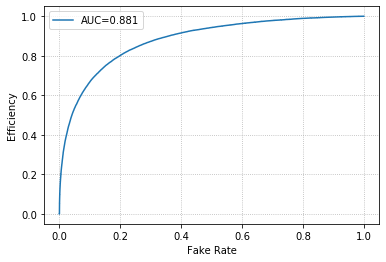

In [63]:
fpr, tpr, _ = roc_curve(y_test.astype(int), predictions[:,0])
AUC = auc(fpr, tpr)
plt.figure()
plt.plot(
    fpr,tpr,
    label = "AUC={:.3f}".format(AUC)
)
plt.legend(loc="best")
plt.grid(which="major",linestyle=":")
plt.xlabel("Fake Rate")
plt.ylabel("Efficiency")
plt.show()

## LRP Analysis

In [64]:
analyzer = innv.create_analyzer(
    "lrp.z",                        # analysis method identifier
    model_ckp                       # model without softmax output
)

analysis = np.zeros([len(x_test), 76])

for i, x in enumerate(x_test):
    a = analyzer.analyze(x.reshape((1,x.shape[0])))
    analysis[i] = a[0]

In [65]:
meanLRP = np.mean(analysis,axis=0)
stdLRP = np.std(analysis,axis=0)

meanLRP_sort, stdLRP_sort, varList_sort = zip(*sorted(zip(
    meanLRP, stdLRP, varList
),reverse=True))

### Plot the LRP for each variable
Positive values suggest contributing to more signal-like properties and negative values suggest contributing to more background-like properties

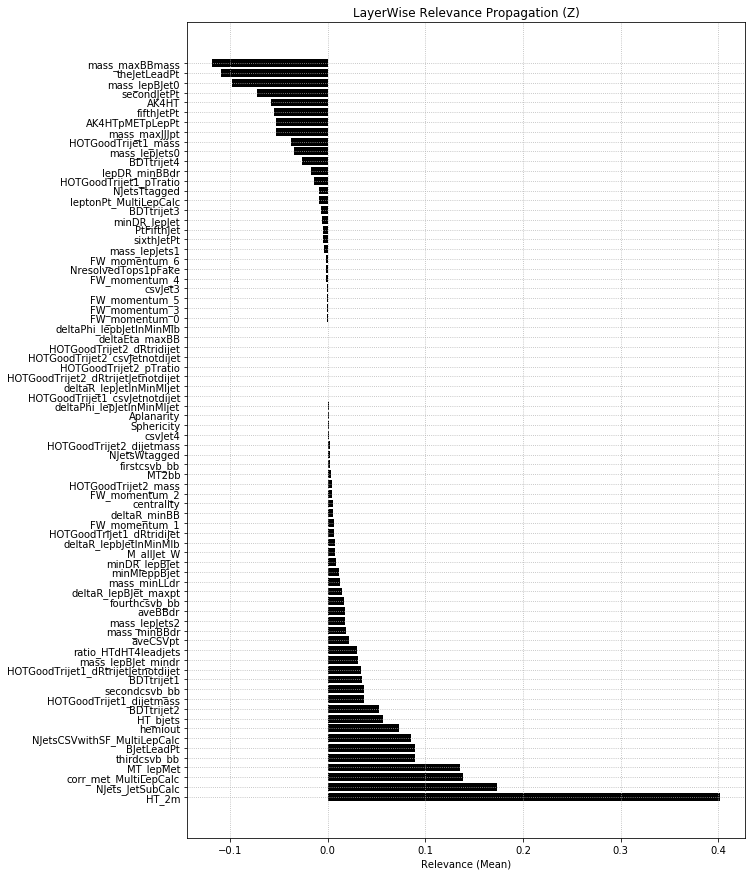

In [66]:
plt.figure(figsize=(10,int(len(varList_sort)/5)))
plt.barh(
    varList_sort, meanLRP_sort, #xerr = stdLRP_sort,
    align = "center", capsize = 5.0, color = "black"
)
plt.title("LayerWise Relevance Propagation (Z)")
plt.grid(which="both",linestyle=":")
plt.xlabel("Relevance (Mean)")
plt.show()

In [67]:
colorRank = []
meanAbsLRP = np.mean(abs(analysis),axis=0)
stdAbsLRP = np.std(abs(analysis),axis=0)

for i, var in enumerate(varList):
    if meanLRP[i] > 0: colorRank.append("green")
    else: colorRank.append("blue")
        
meanAbsLRP_sort, colorRank_sort, varListAbs_sort = zip(*sorted(zip(
    abs(meanAbsLRP), colorRank, varList
),reverse=False))

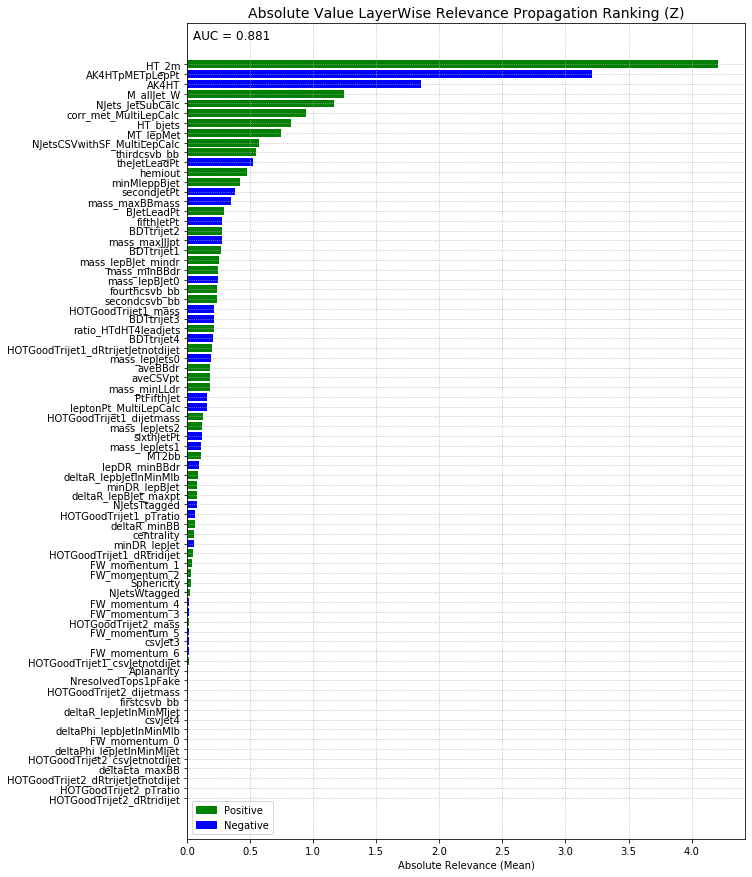

In [68]:
plt.figure(figsize=(10,int(len(varList_sort)/5)))
plt.barh(
    varListAbs_sort, meanAbsLRP_sort,# xerr = stdLRP_sort,
    align = "center", capsize = 5.0, color = colorRank_sort
)
plt.title("Absolute Value LayerWise Relevance Propagation Ranking (Z)",fontsize=14)
green_patch = mpatches.Patch(color="green",label="Positive")
blue_patch = mpatches.Patch(color="blue",label="Negative")
plt.legend(loc="best",handles=[green_patch,blue_patch])
plt.grid(which="both",linestyle=":")
plt.xlabel("Absolute Relevance (Mean)")
plt.annotate(
    "AUC = {:.3f}".format(AUC),
    xycoords = "axes pixels",
    xy = (6,800),
    fontsize=12
)
plt.show()